In [2]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import validation_curve

from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [3]:
import sklearn

In [4]:
pd.set_option('display.max_columns',None)

## Import cleaned dataset
### Simple model using just Abn% + demographics

In [5]:
pos_final_test = pd.read_csv('../data/pos_KNN_final_test_trimmed.csv.gz', compression='gzip')

non_lab_cols = [ 'gender','age',\
                'ethnicity_AMERICAN INDIAN/ALASKA NATIVE', 'ethnicity_ASIAN','ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_HISPANIC/LATINO','ethnicity_OTHER', 'ethnicity_UNKNOWN',\
                'ed_length', 'insurance_Medicare','insurance_Medicaid'\
               'pneumoia', 'diabetes','hypertension' ,'atherosclero','renal_failure' ,'arrhythmia']
model_cols = pos_final_test.columns.str.contains('max')|pos_final_test.columns.str.contains('min')|pos_final_test.columns.str.contains('abn')|pos_final_test.columns.str.contains('mean') | pos_final_test.columns.str.contains('below') |pos_final_test.columns.str.contains('above') | pos_final_test.columns.isin(non_lab_cols)
hadm_features = pos_final_test.loc[:, model_cols]
hadm_target = pos_final_test.loc[:, 'pos']

In [6]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# hadm_features['ethnicity'] = le.fit_transform(hadm_features['ethnicity'])
# hadm_features['gender'] = le.fit_transform(hadm_features['gender'])

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# hadm_features['age'] = scaler.fit_transform(hadm_features['age'].values.reshape(-1, 1))

In [7]:
# hadm_features.corr()

## Train test split

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(hadm_features, hadm_target, test_size=.2, stratify=hadm_target, random_state=25)

In [9]:
# Over and under sample the train set
sm = SMOTE()
X_res_over, y_res_over = sm.fit_resample(X_train, y_train)

nm = NearMiss()
X_res_under, y_res_under = nm.fit_resample(X_train, y_train)

In [10]:
# check target counts
print('Target=0: ',hadm_target[hadm_target==0].count())
print('Target=1: ',hadm_target[hadm_target==1].count())

Target=0:  7309
Target=1:  1282


In [11]:
hadm_features

,"('min', 'Anion Gap - Blood - Chemistry')","('min', 'Creatine Kinase, MB Isoenzyme - Blood - Chemistry')","('min', 'Creatinine - Blood - Chemistry')","('min', 'Glucose - Blood - Chemistry')","('min', 'Phosphate - Blood - Chemistry')","('min', 'Potassium - Blood - Chemistry')","('min', 'Troponin T - Blood - Chemistry')","('min', 'Urea Nitrogen - Blood - Chemistry')","('min', 'MCV - Blood - Hematology')","('min', 'Platelet Count - Blood - Hematology')","('min', 'PT - Blood - Hematology')","('min', 'RDW - Blood - Hematology')","('min', 'White Blood Cells - Blood - Hematology')","('min', 'Bilirubin - Urine - Hematology')","('max', 'Anion Gap - Blood - Chemistry')","('max', 'Bicarbonate - Blood - Chemistry')","('max', 'Calcium, Total - Blood - Chemistry')","('max', 'Estimated GFR (MDRD equation) - Blood - Chemistry')","('max', 'Sodium - Blood - Chemistry')","('max', 'Hematocrit - Blood - Hematology')","('max', 'MCHC - Blood - Hematology')","('mean', 'Magnesium - Blood - Chemistry')","('abn_percent', 'Anion Gap - Blood - Chemistry')","('abn_percent', 'Bicarbonate - Blood - Chemistry')","('abn_percent', 'Calcium, Total - Blood - Chemistry')","('abn_percent', 'Chloride - Blood - Chemistry')","('abn_percent', 'Creatine Kinase, MB Isoenzyme - Blood - Chemistry')","('abn_percent', 'Creatinine - Blood - Chemistry')","('abn_percent', 'Estimated GFR (MDRD equation) - Blood - Chemistry')","('abn_percent', 'Glucose - Blood - Chemistry')","('abn_percent', 'Magnesium - Blood - Chemistry')","('abn_percent', 'Phosphate - Blood - Chemistry')","('abn_percent', 'Potassium - Blood - Chemistry')","('abn_percent', 'Sodium - Blood - Chemistry')","('abn_percent', 'Troponin T - Blood - Chemistry')","('abn_percent', 'Urea Nitrogen - Blood - Chemistry')","('abn_percent', 'Hematocrit - Blood - Hematology')","('abn_percent', 'Hemoglobin - Blood - Hematology')","('abn_percent', 'MCH - Blood - Hematology')","('abn_percent', 'MCHC - Blood - Hematology')","('abn_percent', 'MCV - Blood - Hematology')","('abn_percent', 'Platelet Count - Blood - Hematology')","('abn_percent', 'PT - Blood - Hematology')","('abn_percent', 'RDW - Blood - Hematology')","('abn_percent', 'Red Blood Cells - Blood - Hematology')","('abn_percent', 'White Blood Cells - Blood - Hematology')","('abn_percent', 'Bilirubin - Urine - Hematology')","('below_min', 'Anion Gap - Blood - Chemistry')","('below_min', 'Bicarbonate - Blood - Chemistry')","('below_min', 'Calcium, Total - Blood - Chemistry')","('below_min', 'Chloride - Blood - Chemistry')","('below_min', 'Creatine Kinase, MB Isoenzyme - Blood - Chemistry')","('below_min', 'Creatinine - Blood - Chemistry')","('below_min', 'Glucose - Blood - Chemistry')","('below_min', 'Magnesium - Blood - Chemistry')","('below_min', 'Phosphate - Blood - Chemistry')","('below_min', 'Potassium - Blood - Chemistry')","('below_min', 'Sodium - Blood - Chemistry')","('below_min', 'Troponin T - Blood - Chemistry')","('below_min', 'Urea Nitrogen - Blood - Chemistry')","('below_min', 'Hematocrit - Blood - Hematology')","('below_min', 'MCHC - Blood - Hematology')","('below_min', 'MCV - Blood - Hematology')","('below_min', 'Platelet Count - Blood - Hematology')","('below_min', 'PT - Blood - Hematology')","('below_min', 'RDW - Blood - Hematology')","('below_min', 'White Blood Cells - Blood - Hematology')","('below_min', 'Bilirubin - Urine - Hematology')","('above_max', 'Anion Gap - Blood - Chemistry')","('above_max', 'Bicarbonate - Blood - Chemistry')","('above_max', 'Calcium, Total - Blood - Chemistry')","('above_max', 'Chloride - Blood - Chemistry')","('above_max', 'Creatine Kinase, MB Isoenzyme - Blood - Chemistry')","('above_max', 'Estimated GFR (MDRD equation) - Blood - Chemistry')","('above_max', 'Glucose - Blood - Chemistry')","('above_max', 'Magnesium - Blood - Chemistry')","('above_max', 'Phosphate - Blood - Chemistry')","('above_max', 'Potassium - Blood - Chemistry')","('above_max', 'Sodium - Blood - Chemistry')","('above_max', 'Urea Nitrogen - Blood - Chemistr

## Functions used in this notebook

In [12]:
def results(model, X=X_test, y=y_test):
    '''
    Function to report on the metrics of a GridSearch model.
    Input: GridSearchCV model
    Prints: CV score, best parameters, accuracy, precision, recall, F1, confusion matrix and ROCAUC
    '''
    
#     cross validation scores
    print("Cross Validation")
    print("-" * 20)
    print("Best parameter: ", model.best_params_)
    print("Best CV score:  %.4f" % model.best_score_)

#     confusion matrix & related scores
    pred = model.best_estimator_.predict(X)
    print(f"Accuracy Score: {accuracy_score(y, pred) * 100:.2f}%")
    print("_______________________________________________")
    print("Classification Report:", end='')
    print(f"\tPrecision Score: {precision_score(y, pred) * 100:.2f}%")
    print(f"\t\t\tRecall Score: {recall_score(y, pred) * 100:.2f}%")
    print(f"\t\t\tF1 score: {f1_score(y, pred) * 100:.2f}%")
    print(f"\t\t\tROC_AUC score: {roc_auc_score(y, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(y, pred)}\n")
    
    svc_disp = plot_roc_curve(model, X, y)
    plt.show()
    
    if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
        est_coefs = pd.Series(model.best_estimator_.coef_[0], index=X.columns)
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        print(sortedCoefs[sortedCoefs > 0].head(25))
      
    else:
        est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X.columns)
        sortedCoefs = est_coefs.sort_values(ascending=False)
        print(sortedCoefs.head(25))

In [13]:
def change_threshold(model, threshold_list, X=X_test):
    '''
    Input a model and threshold_list.
    Output scores based on prediction made with threshold list.
    '''
    metrics = pd.DataFrame(columns = ['Threshold','F1','ROC_AUC','Recall','Accuracy','Precision'])
    
    for threshold in threshold_list:
        prob = model.best_estimator_.predict_proba(X)[:,1]
        pred = np.where(prob>threshold,1,0)


        f1 = f1_score(y_test, pred)
        roc_auc = roc_auc_score(y_test, pred)
        recall = recall_score(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred)

        metrics = metrics.append({'Threshold':threshold,
                                  'F1':f1,
                                  'ROC_AUC':roc_auc,
                                  'Recall':recall,
                                  'Accuracy':accuracy,
                                  'Precision':precision}
                                 ,ignore_index=True)
        
    plt.plot(metrics.Threshold, metrics.Recall, label='Recall', color='green')
    plt.plot(metrics.Threshold, metrics.Precision, label='Precision', color='blue')
    plt.plot(metrics.Threshold, metrics.ROC_AUC, label='ROC_AUC', color='red')
    plt.legend()
    plt.xlabel('Threshold')
    plt.ylabel('Scores')
    return metrics

In [14]:
def plot_val_curve(estimator, feature, feature_range, X, y):
    '''
    Plots validation curve for an estimator and a feature for a specified feature range.
    Used to determine range of feature to use for hyperparameter tuning for GridSearchCV.
    '''
    train_scores, valid_scores = validation_curve(estimator, 
                                                  X,y,
                                                  feature,
                                                  feature_range, 
                                                  scoring='recall',cv=3)
    plt.plot(feature_range,train_scores)
    plt.plot(feature_range,valid_scores,linestyle='--')
    plt.xlabel(feature)
    plt.ylabel('recall')

In [15]:
def gather_best_features(model_list):
    best_features = pd.DataFrame()

    for model, model_name,X in model_list:
        if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
            est_coefs = pd.Series(model.best_estimator_.coef_[0], index=X.columns)
        else:
            est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X.columns)
            
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        sorted_df = pd.DataFrame(sortedCoefs).reset_index().rename(columns={"index":'features', 0: model_name})
        best_features = pd.concat([best_features, sorted_df], axis=1)
    return best_features

## Logistic Regression

### Basic

In [17]:
# %%time

# params ={'C':np.linspace(1e-2,1,20)}
# logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

# grid_log = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
# grid_log.fit(X_train, y_train)

In [18]:
# %%time
# results(grid_log)

In [19]:
# threshold_list = np.linspace(0.01,0.5,10)
# change_threshold(grid_log, threshold_list, X_test)

In [20]:
# from sklearn.feature_selection import RFECV
# selector = RFECV(grid_log.best_estimator_, step=1, cv=5, scoring ='roc_auc')
# selector = selector.fit(X_train, y_train)
# selector.support_

In [24]:
# pd.Series(grid_log.best_estimator_.coef_[0], index=X_train.columns)
# orig_columns=X_train.columns.to_frame().reset_index()[[0]]
# orig_columns[selector.support_]

In [21]:
# X_reduced = selector.transform(X_train)
# grid_log_reduced = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
# grid_log_reduced.fit(X_reduced, y_train)

In [22]:
# est_coefs = pd.Series(grid_log_reduced.best_estimator_.coef_[0], index=X_train.iloc[:,selector.support_].columns)
# sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
# sortedCoefs[sortedCoefs>0]


In [23]:
# X_test_reduced = selector.transform(X_test)

In [24]:
# change_threshold(grid_log_reduced, threshold_list,X_test_reduced)

In [25]:
# # (2nd round of feature reduction) Remove features with coef 0 and run lasso logistic regression again
# X_train_reduced_2 = X_train.loc[:,sortedCoefs[sortedCoefs>0].index]
# X_test_reduced_2 = X_test.loc[:,sortedCoefs[sortedCoefs>0].index]
# grid_log_reduced_2 = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
# grid_log_reduced_2.fit(X_train_reduced_2, y_train)

In [26]:
# grid_log_reduced_2.best_estimator_.get_params

In [27]:
# change_threshold(grid_log_reduced_2, threshold_list,X_test_reduced_2)

In [28]:
# est_coefs = pd.Series(grid_log_reduced_2.best_estimator_.coef_[0], index=X_train_reduced_2.columns)
# sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
# # sortedCoefs[sortedCoefs>0]
# sortedCoefs.head(50)

In [29]:
# # (3rd round of feature reduction) Remove features with coef 0 and run lasso logistic regression again
# X_train_reduced_3 = X_train.loc[:,sortedCoefs[sortedCoefs>0].index]
# X_test_reduced_3 = X_test.loc[:,sortedCoefs[sortedCoefs>0].index]
# grid_log_reduced_3 = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
# grid_log_reduced_3.fit(X_train_reduced_3, y_train)

In [30]:
# grid_log_reduced_3.best_estimator_.get_params

In [31]:
# change_threshold(grid_log_reduced_3, threshold_list,X_test_reduced_3)

In [32]:
# est_coefs = pd.Series(grid_log_reduced_3.best_estimator_.coef_[0], index=X_train_reduced_3.columns)
# sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
# # sortedCoefs[sortedCoefs>0]
# sortedCoefs

In [33]:
# sortedCoefs.index

In [34]:
# # (4th round of feature reduction) Remove features with coef 0 and run lasso logistic regression again
# X_train_reduced_4 = X_train.loc[:,sortedCoefs[sortedCoefs>0].index]
# X_test_reduced_4 = X_test.loc[:,sortedCoefs[sortedCoefs>0].index]
# grid_log_reduced_4 = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
# grid_log_reduced_4.fit(X_train_reduced_4, y_train)

In [35]:
# grid_log_reduced_4.best_estimator_.get_params

In [36]:
# change_threshold(grid_log_reduced_4, threshold_list,X_test_reduced_4)

In [37]:
# est_coefs = pd.Series(grid_log_reduced_4.best_estimator_.coef_[0], index=X_train_reduced_4.columns)
# sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
# # sortedCoefs[sortedCoefs>0]
# sortedCoefs

## Random Forest

In [19]:
from sklearn.feature_selection import RFECV
selector = RFECV(RandomForestClassifier(), step=1, cv=5, scoring ='roc_auc')
# selector = selector.fit(X_train, y_train)
# selector.support_

In [20]:
selector_rf_over = RFECV(RandomForestClassifier(), step=1, cv=5, scoring ='roc_auc')
selector_rf_over = selector.fit(X_res_over, y_res_over)
selector_rf_over.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [21]:
X_res_over_rf_reduced = X_res_over.iloc[:,selector_rf_over.support_]

In [25]:
X_res_over_rf_reduced.shape

(11694, 101)

### RF_Over Sampling using SMOTE

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=max_depth, param_range=range(2, 35, 3) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


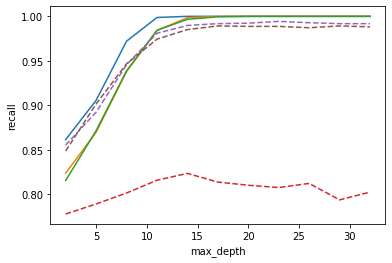

In [22]:
plot_val_curve(RandomForestClassifier(), 'max_depth', range(2,35,3), X_res_over_rf_reduced, y_res_over)

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=n_estimators, param_range=range(10, 300, 100) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


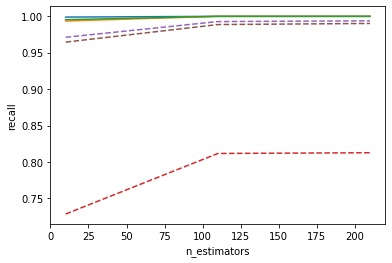

In [23]:
plot_val_curve(RandomForestClassifier(), 'n_estimators', range(10,300,100), X_res_over_rf_reduced, y_res_over)

In [24]:
%%time
param_grid={'n_estimators': range(200,201,1),
            'max_depth': range(8,15,3)
            }

grid_rf_over = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_rf_over.fit(X_res_over_rf_reduced, y_res_over)

CPU times: user 1min 3s, sys: 1.63 s, total: 1min 4s
Wall time: 1min 29s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(8, 15, 3),
                         'n_estimators': range(200, 201)},
             scoring='roc_auc')

In [77]:
# results(grid_rf_over)

In [78]:
X_test_rf_over_reduced = X_test.iloc[:,selector_rf_over.support_]

In [26]:
X_test_rf_over_reduced.shape

NameError: name 'X_test_rf_over_reduced' is not defined

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.010000,0.268407,0.520862,1.000000,0.184991,0.155006
1,0.023571,0.286991,0.563269,1.000000,0.257126,0.167536
2,0.037143,0.300177,0.590158,0.992218,0.308319,0.176838
3,0.050714,0.315332,0.617966,0.988327,0.358348,0.187592
4,0.064286,0.327296,0.637909,0.984436,0.394997,0.196276
5,0.077857,0.341463,0.659561,0.980545,0.434555,0.206727
6,0.091429,0.354701,0.677322,0.968872,0.472949,0.217088
7,0.105000,0.360704,0.684140,0.957198,0.492728,0.222222
8,0.118571,0.371844,0.696771,0.945525,0.522397,0.231429
9,0.132143,0.379747,0.704614,0.933852,0.543921,0.238332


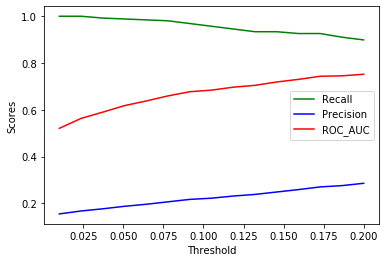

In [81]:
threshold_list = np.linspace(0.01,0.2,15)
change_threshold(grid_rf_over, threshold_list, X_test_rf_over_reduced)

### RF_Under Sampling using Near Miss

In [42]:
# plot_val_curve(RandomForestClassifier(), 'max_depth', range(2,20,3), X_res_under, y_res_under)

In [43]:
# plot_val_curve(RandomForestClassifier(), 'n_estimators', range(75,200,50), X_res_under, y_res_under)

In [44]:
# %%time
# param_grid={'n_estimators': range(200,201,1),
#             'max_depth': range(3,7,1)
#             }

# grid_rf_under = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
# grid_rf_under.fit(X_res_under, y_res_under)

In [45]:
# results(grid_rf_under)

In [46]:
# change_threshold(grid_rf_under, threshold_list)

## Gradient Boost

### GB_Over Sampling using SMOTE¶

In [48]:
selector_gb_over = RFECV(GradientBoostingClassifier(), step=1, cv=5, scoring ='roc_auc')
selector_gb_over = selector.fit(X_res_over, y_res_over)
selector_gb_over.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False,  True,  True,  True,  True,  True])

In [82]:
X_res_over_gb_reduced = X_res_over.iloc[:,selector_gb_over.support_]
X_test_gb_over_reduced = X_test.iloc[:,selector_gb_over.support_]

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=max_depth, param_range=range(3, 20, 5) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


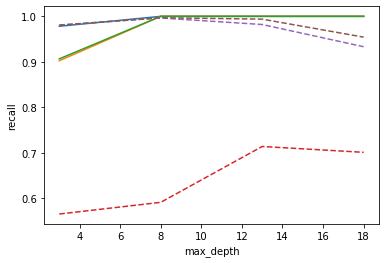

In [108]:
plot_val_curve(GradientBoostingClassifier(), 'max_depth', range(3,20,5), X_res_over_gb_reduced, y_res_over)

In [101]:
%%time
param_grid={'n_estimators': range(250,251,1),
            'max_depth': range(8,13,1)
            }

grid_gb_over = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid,
                                            cv=3, scoring='recall')
grid_gb_over.fit(X_res_over_gb_reduced, y_res_over)

CPU times: user 23min 29s, sys: 17.2 s, total: 23min 46s
Wall time: 26min 1s


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': range(8, 13),
                         'n_estimators': range(250, 251)},
             scoring='recall')

Cross Validation
--------------------
Best parameter:  {'max_depth': 12, 'n_estimators': 250}
Best CV score:  0.8893
Accuracy Score: 86.39%
_______________________________________________
Classification Report:	Precision Score: 57.82%
			Recall Score: 33.07%
			F1 score: 42.08%
			ROC_AUC score: 64.42%
_______________________________________________
Confusion Matrix: 
 [[1400   62]
 [ 172   85]]



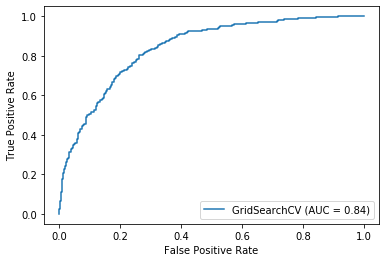

('above_max', 'Urea Nitrogen - Blood - Chemistry')              0.217725
insurance_Medicare                                              0.157267
age                                                             0.037005
('below_min', 'Urea Nitrogen - Blood - Chemistry')              0.033000
('abn_percent', 'Troponin T - Blood - Chemistry')               0.030271
('max', 'Bicarbonate - Blood - Chemistry')                      0.023337
('max', 'MCHC - Blood - Hematology')                            0.017571
('min', 'RDW - Blood - Hematology')                             0.015949
('above_max', 'PT - Blood - Hematology')                        0.015343
('above_max', 'RDW - Blood - Hematology')                       0.015077
('below_min', 'MCHC - Blood - Hematology')                      0.012979
('abn_percent', 'Calcium, Total - Blood - Chemistry')           0.012305
('min', 'Creatinine - Blood - Chemistry')                       0.012281
('mean', 'Magnesium - Blood - Chemistry')          

In [102]:
results(grid_gb_over, X_test_gb_over_reduced)

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.010,0.492255,0.716309,0.556420,0.828389,0.441358
1,0.045,0.491228,0.700677,0.490272,0.848168,0.492188
2,0.080,0.472050,0.683486,0.443580,0.851658,0.504425
3,0.115,0.471338,0.680728,0.431907,0.855148,0.518692
4,0.150,0.459519,0.671790,0.408560,0.856312,0.525000
5,0.185,0.455357,0.668006,0.396887,0.858057,0.534031
6,0.220,0.445946,0.662511,0.385214,0.856894,0.529412
7,0.255,0.437358,0.657359,0.373541,0.856312,0.527473
8,0.290,0.425926,0.650603,0.357977,0.855730,0.525714
9,0.325,0.430913,0.652313,0.357977,0.858639,0.541176


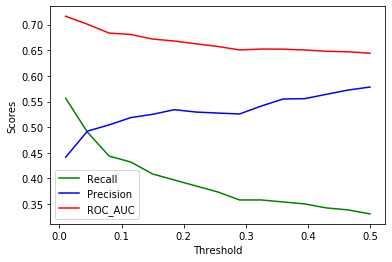

In [105]:
threshold_list = np.linspace(0.01,0.5,15)
change_threshold(grid_gb_over, threshold_list, X_test_gb_over_reduced)

In [237]:
# %%time
# param_grid={'n_estimators':range(150,151,1),
#             'max_depth':range(13,14,1),
# #             'min_samples_split':range(20,100,30),
#             'max_features':range(8,17,2),
#             }
# # 'max_depth': 9, 'n_estimators': 80
# grid_gb_over = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
# grid_gb_over.fit(X_res_over, y_res_over)

In [238]:
# results(grid_gb_over)

### GB_Under Sampling using Near Miss

In [109]:
selector_gb_under = RFECV(GradientBoostingClassifier(), step=1, cv=5, scoring ='roc_auc')
selector_gb_under = selector.fit(X_res_under, y_res_under)
selector_gb_under.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False,  True, False, False,  True,  True])

In [118]:
X_res_under_gb_reduced = X_res_under.iloc[:,selector_gb_under.support_]
X_test_gb_under_reduced = X_test.iloc[:,selector_gb_under.support_]

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=max_depth, param_range=range(2, 7) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


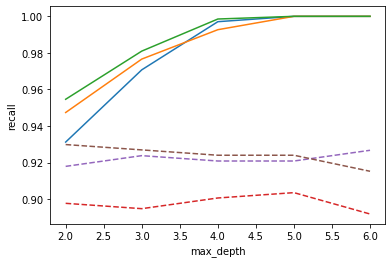

In [120]:
plot_val_curve(GradientBoostingClassifier(), 'max_depth', range(2,7,1),X_res_under_gb_reduced, y_res_under)

In [119]:
# X_res_under_gb_reduced.shape
# # X_res_under.shape

(2050, 93)

In [121]:
%%time
param_grid={'n_estimators':range(250,251,1),
            'max_depth':range(3,6,1),
            }

grid_gb_under = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_gb_under.fit(X_res_under_gb_reduced, y_res_under)

CPU times: user 49.5 s, sys: 1.14 s, total: 50.6 s
Wall time: 1min 6s


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': range(3, 6),
                         'n_estimators': range(250, 251)},
             scoring='roc_auc')

In [90]:
# results(grid_gb_under)

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.010000,0.280682,0.549803,0.992218,0.239674,0.163462
1,0.026897,0.300236,0.590265,0.988327,0.311227,0.177003
2,0.043793,0.308537,0.605761,0.984436,0.340314,0.182936
3,0.060690,0.312968,0.613498,0.976654,0.358930,0.186340
4,0.077586,0.317058,0.620444,0.972763,0.373473,0.189394
5,0.094483,0.321498,0.627733,0.968872,0.388598,0.192724
6,0.111379,0.322917,0.629891,0.964981,0.394997,0.193901
7,0.128276,0.326288,0.635128,0.961089,0.406632,0.196500
8,0.145172,0.326174,0.634185,0.945525,0.415939,0.197080
9,0.162069,0.325456,0.632688,0.937743,0.418848,0.196895


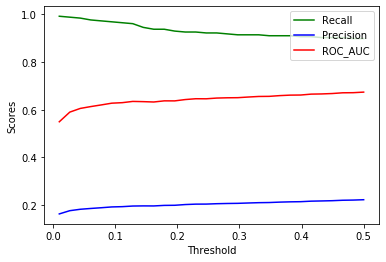

In [124]:
threshold_list = np.linspace(0.01,0.5,30)
change_threshold(grid_gb_under, threshold_list, X_test_gb_under_reduced)

In [241]:
# %%time
# param_grid={'n_estimators':range(80,81,1),
#             'max_depth':range(2,9,2),
# #             'min_samples_split':range(20,100,30),
#             'max_features':range(7,12,2),
#             }

# grid_gb_under = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
# grid_gb_under.fit(X_res_under, y_res_under)

In [242]:
# results(grid_gb_under)

## Gather Metrics

In [45]:
def gather_metrics(model_list):
    '''
    Gathers metrics from models in model_list and returns a dataframe of gathered metrics.
    '''
    metrics = pd.DataFrame(columns = ['Model','F1','ROC_AUC','Recall','Accuracy','Precision'])
    
    for model, model_name in model_list:
        pred = model.best_estimator_.predict(X_test)
        
        f1 = f1_score(y_test, pred)
        roc_auc = roc_auc_score(y_test, pred)
        recall = recall_score(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred)
        
        metrics = metrics.append({'Model':model_name,
                                  'F1':f1,
                                  'ROC_AUC':roc_auc,
                                  'Recall':recall,
                                  'Accuracy':accuracy,
                                  'Precision':precision}
                                 ,ignore_index=True)
#         print(model_name,' processed')
    return metrics

In [92]:
# model_list=[(grid_log,'logistic_basic'),(grid_log_under,'logistic_under'),(grid_log_over,'logistic_over'), 
#             (grid_gb_under,'gradient_boost_under'),(grid_gb_over,'gradient_boost_over'),
#             (grid_rf_under,'random_forest_under'),(grid_rf_over,'random_forest_over')
#            ]
# gather_metrics(model_list)

## Gather Best Features

In [127]:
model_list=[
            (grid_gb_under,'gradient_boost_under', X_test_gb_under_reduced),
            (grid_rf_over,'random_forest_over',X_test_rf_over_reduced)
           ]
gather_best_features(model_list).head(50)

,features,gradient_boost_under,features,random_forest_over
0,"('abn_percent', 'Urea Nitrogen - Blood - Chemi...",0.327359,insurance_Medicare,0.073288
1,"('abn_percent', 'PT - Blood - Hematology')",0.074677,"('above_max', 'Urea Nitrogen - Blood - Chemist...",0.061960
2,"('abn_percent', 'RDW - Blood - Hematology')",0.060434,age,0.056254
3,"('min', 'Potassium - Blood - Chemistry')",0.053920,"('abn_percent', 'Urea Nitrogen - Blood - Chemi...",0.042554
4,"('min', 'Platelet Count - Blood - Hematology')",0.044283,"('abn_percent', 'Troponin T - Blood - Chemistry')",0.031622
5,"('abn_percent', 'Troponin T - Blood - Chemistry')",0.038479,"('min', 'Urea Nitrogen - Blood - Chemistry')",0.029857
6,age,0.033939,gender,0.025770
7,"('min', 'RDW - Blood - Hematology')",0.031319,"('max', 'Bicarbonate - Blood - Chemistry')",0.023336
8,"('above_max', 'Urea Nitrogen - Blood - Chemist...",0.025679,"('min', 'RDW - Blood - Hematology')",0.021691
9,"('max', 'Anion Gap - Blood - Chemistry')",0.025287,"('above_max', 'RDW - Blood - Hematology')",0.020553
